In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from scipy.sparse import csr_matrix
from fuzzywuzzy import fuzz
import re

In [3]:
import warnings
warnings.filterwarnings('ignore')

# user.json

See older versions of the file to retrieve the code!

# CSV file from 'business.json'

In [4]:
# Reading in 'extacted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [5]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [6]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


# CSV file from 'review.json'

In [7]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [8]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"}).head()

,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


# Modeling

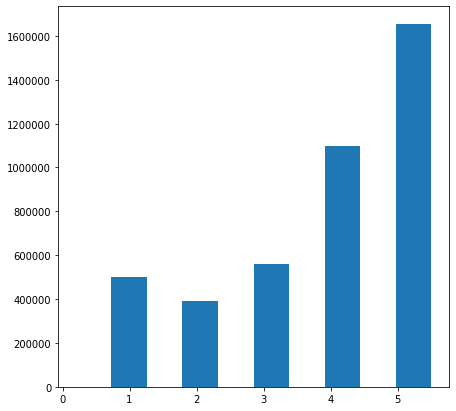

In [9]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, range = (0.2,5.5), bins = 10)
plt.show()

In [11]:
# Random EDA
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))
testset = rest_review_csvTOpd[:1000]
category = testset.stars
testset.head()

There are 4201685 restaurant reviews.


,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [12]:
one_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 1.0]
two_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 2.0]
three_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 3.0]
four_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 4.0]
five_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 5.0]

In [13]:
# Figuring out what percentage of the "rest_review_csvTOpd" should be training data, and what percentage should be test data.
num_train_data = int(rest_review_length * 0.8)
print("For 80% of the data, there should be {} reviews.".format(num_train_data))

For 80% of the data, there should be 3361348 reviews.


In [14]:
# Train data has equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], three_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], three_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

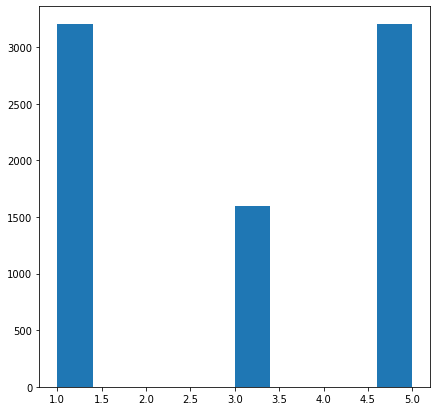

In [15]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, range = (1,5), bins = 10)
plt.show()

In [16]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
vtrain = vectorizer.fit_transform(train_data)
vdev = vectorizer.transform(test_data)

In [17]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vdev)
f1_score = metrics.f1_score(test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.7645667436311591


In [18]:
lr_classifier.predict_proba(vdev)

array([[0.95321591, 0.01361652, 0.03316756],
       [0.72909956, 0.15708661, 0.11381383],
       [0.8697856 , 0.06072605, 0.06948835],
       ...,
       [0.13702692, 0.11199388, 0.7509792 ],
       [0.07445364, 0.02312043, 0.90242593],
       [0.10455203, 0.11123606, 0.78421191]])

# Sample Prediction

In [19]:
# Predict new sentence
test_sentence = "I hate this place"
test_sentence = [test_sentence]

In [20]:
new_test = vectorizer.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.47168233, 0.172166  , 0.35615168]])

# Predictions without the neutral data

In [21]:
# Throwing away the neutral data
NO3_train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
NO3_train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

NO3_test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
NO3_test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

In [22]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
v_NO3_train = vectorizer.fit_transform(NO3_train_data)
v_NO3_dev = vectorizer.transform(NO3_test_data)

In [23]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.08)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_dev)
f1_score = metrics.f1_score(NO3_test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.917474726635032


* So if we throw out the moderate data (the 3-star reviews), it is clear that there is a difference between positive and negative reviews.

# Restaurant Recommender

We wanted to apply K-NN algorithm to implement our own recommender system for restaurants. We will be using an intem-based collaborative filtering system, where we use patterns of useres who went to the same restaurant to make recommendations. 

For our K-NN Algorithm, we are trying to find our nearest neighbors based off of other users' behavior. If a lot of people visit both Restaurant A and Restaurant B, then the two restaurants are likely to be close neighbors, and we will recommend it to them. 

Can try both user-based and item-based collaborative filtering. 

In [10]:
# restaurant dataset

rest_biz_csvTOpd.head()

,business_id,name,address,city,state,stars,review_count,is_open,attributes,categories,hours
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Breakfast & Brunch, Mexican, Taco...","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W..."
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Italian, Restaurants, Pizza, Chicken Wings","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",NaN


In [11]:
# restaurant reviews dataset

rest_review_csvTOpd.head()

,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [12]:
num_users = len(rest_review_csvTOpd['user_id'].unique())
print("number of unique users:", num_users)

num_rest_review = len(rest_review_csvTOpd['business_id'].unique())
print("number of unique restaurants:", num_rest_review)

number of unique users: 1148099
number of unique restaurants: 59372


For the KNN Model for item-based filtering, we will need to set up a matrix with restaurants for rows and users by columns, so we would getting a 11480909 x 59371 matrix. Pandas throws an error because this matrix is too large to process, so we will decide to focus the model on recommending restaurants by location, specifically by state. It makes sense too. No use in providing recommendations that are in another state and too far away. 

Where are most of the restaurants in the dataset located? 

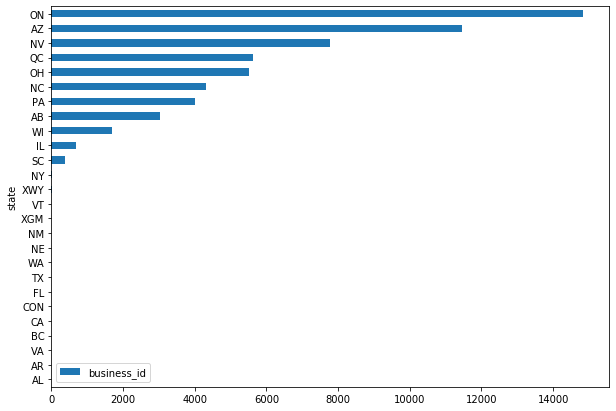

In [13]:
state_count = pd.DataFrame(rest_biz_csvTOpd.groupby('state').count()['business_id']).sort_values(by='business_id', ascending = True)
state_count.plot.barh(figsize = (10, 7))


We also will remove all states below Wisconson(WI) because they don't have enough restaurants for us to do recommendations. 

In [14]:
# Getting restaurants id per state
on_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'ON']['business_id']
az_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'AZ']['business_id']
nv_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'NV']['business_id']
qc_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'QC']['business_id']
oh_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'OH']['business_id']
nc_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'NC']['business_id']
pa_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'PA']['business_id']
ab_rest_id = rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'AB']['business_id']

# Getting data per state
on_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(on_rest_id)]
az_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(az_rest_id)]
nv_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(nv_rest_id)]
qc_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(qc_rest_id)]
oh_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(oh_rest_id)]
nc_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(nc_rest_id)]
pa_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(pa_rest_id)]
ab_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(ab_rest_id)]


Now that we know what kind of data we are working with, we need to process the data so that it can be put into the KNN model for recommendation. Like mentioned above, we need to convert each state's restaurant data into a no. of restaurants x no. of users sized matrix. KNN algorithm will take the matrix and determines a restaurant's neighbors based off of distance between to other restaurants. 

In [55]:
def KNN_matrix(data):
    """takes in [state]_reviews dataframe and returns a sparse matrix and a list for business_id
    to prepare for KNN model zipped up into one object. Beware of long run time"""
    
    matrix = data.pivot_table(index='business_id', columns='user_id', values = 'stars', aggfunc = 'mean').fillna(0)
    sparse_matrix = csr_matrix(matrix)
    
    business_id = list(matrix.index)
    business_names = []
    for i in business_id:
        business_names.append(list(rest_biz_csvTOpd[rest_biz_csvTOpd['business_id'] == i]['name'])[0])
        
    return zip(sparse_matrix, business_id, business_names)
                    
pa_sparse = KNN_matrix(pa_reviews)

# print(pa_sparse)


# pa_reviews.shape
# print(az_reviews.shape)
# print(len(az_reviews['business_id'].unique()))
# print(len(az_reviews['user_id'].unique()))
# print(on_reviews.shape)
# print(len(on_reviews['business_id'].unique()))
# print(len(on_reviews['user_id'].unique()))

Now that we have the sparse matrix ready, lets fit a KNN model.


In [16]:
knn_model = NearestNeighbors(metric='cosine', n_neighbors = 10)
knn_model.fit(pa_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [52]:
def restaurant_recommender(model, sparse_matrix, n_recommendations = 5, fav_restaurant = None):
    """takes in knn_model, a sparse matrix processed by KNN_matrix, and fav_restaurant which is restaurant on 
    which model makes recommendation"""
    
#     if fav_restaurant = None:
#    find some restaurant to recommend. 
        
    # get a fuzzy match
    # reassign fav_restaurant
    
    matrix, business_id, business_names = zip(*sparse_matrix)

    
    print(sparse_business_id)
    print(business_names)
    
    fav_business_id = rest_biz_csvTOpd[rest_biz_csvTOpd['name'] == fav_restaurant].iloc[0, 0]
    fav_business_index = sparse_business_id.index(fav_business_id)
    distances, indices = model.kneighbors(sparse_matrix[fav_business_index], n_neighbors = n_recommendations + 1)
    
    for i, rest_id in enumerate(indices[0]):
        if i == 0:
            restaurant_id = sparse_business_id[rest_id]
            fav_rest = list(rest_biz_csvTOpd[rest_biz_csvTOpd['business_id'] == restaurant_id]['name'])[0]
            print('Your favorite restaurant is:', fav_rest, '\n')
            print('Here are some other restaurants that people visited: \n')
        else:
            restaurant_id = sparse_business_id[rest_id]
            print(i,'.',list(rest_biz_csvTOpd[rest_biz_csvTOpd['business_id'] == restaurant_id]['name'])[0])
    
    
fav_restaurant = "Ron's Pizza Palace"
    
restaurant_recommender(knn_model, pa_sparse, 5, fav_restaurant)
pa_sparse.index


['--GM_ORV2cYS-h38DSaCLw', '--ujyvoQlwVoBgMYtADiLA', '-1xCh7Cocn6IwFzhELyohA', '-2dlgoN1ass-zmrE5rqHGw', '-382X_bWhJKPJKP1VfXOmw', '-3rvpkYkYD_N1IP4hSvD0A', '-40RDS4F54qiGiEQUsZaXA', '-7H-oXvCxJzuT42ky6Db0g', '-7PX_FOoCwktlunImRyZdg', '-7teXSpi9nqy58WUd-8yfw', '-8F04F54iDT6VgWPCgybug', '-8ILwSisSrTzcyy_Z0o9oA', '-AtzcXIwEP6yO7rM9CM9ww', '-BuZrOMqgO4OU_UKYSddAg', '-CfqFIH6rxUxJL9gR-k_XA', '-DUQQsE2QvFIuqO5EiChQA', '-Enu_Cc8lJ-yVcRvatf0hw', '-Ewxv_Wc1uQzJQQBeQJWyA', '-FcuxZqsQ0FO35GEXExwjw', '-HLGtKB3XtyawZAuvNoQjQ', '-HgbBv9Yjqv735F9fwCZNg', '-IFq5ULEK4Fl8ZzrArtB5g', '-InU2nAbC9AuS-Um2Cowgw', '-Is6Ney1wmsJAjvDdkaaaQ', '-JjKeyuY8h2gbV1FcpiYcQ', '-Js0NjBhIXdH343IDLeKpA', '-Kw6QNbBBgextJZlhtIq9w', '-LiVt5oFhC-AA4nCH77DjQ', '-Lovf0jkQtvb6Y_WjDn-sw', '-N94ldMGlQw_SHdfm2pi_A', '-O7uy8mcz1UEO-D604dRPw', '-OHcd6mJL90wiQYE1e3gGg', '-ORqiS4L-8pq3dLsUazXTg', '-R2kwt0qMnzwEdAfXPvkXg', '-RQCdTsH5rkG702auLcEqA', '-Rsv3qjpn46VK3pBiJxPxg', '-RxzvvyKBOPOzeTvagqEfg', '-SChP5zffbKeXWsJ6Rz5ig', '-SX8276QNj

AttributeError: index not found

In [27]:
rest_biz_csvTOpd[rest_biz_csvTOpd['state'] == 'PA'].head(10)

,business_id,name,address,city,state,stars,review_count,is_open,attributes,categories,hours
5,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Pittsburgh,PA,4.0,35,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Sandwiches, Salad, Restaurants, Burgers, Comfo...",NaN
14,dQj5DLZjeDK3KFysh1SYOQ,Apteka,4606 Penn Ave,Pittsburgh,PA,4.5,242,1,"{'CoatCheck': 'False', 'BusinessParking': ""{'g...","Nightlife, Bars, Polish, Modern European, Rest...","{'Wednesday': '17:0-0:0', 'Thursday': '17:0-0:..."
16,v-scZMU6jhnmV955RSzGJw,No. 1 Sushi Sushi,436 Market St,Pittsburgh,PA,4.5,106,1,"{'OutdoorSeating': 'False', 'HasTV': 'True', '...","Japanese, Sushi Bars, Restaurants","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
18,KFbUQ-RR2UOV62Ep7WnXHw,Westwood Bar & Grill,825 Commonwealth Ave,West Mifflin,PA,3.0,5,1,"{'GoodForMeal': ""{'dessert': False, 'latenight...","American (Traditional), Restaurants","{'Wednesday': '11:0-0:0', 'Thursday': '11:0-0:..."
41,t-6tdxRaz7s9a0sf94Tguw,Impressionz,6008 Broad St,Pittsburgh,PA,4.5,29,0,"{'RestaurantsDelivery': 'False', 'RestaurantsG...","Restaurants, Caribbean","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
53,5WMIvoMx3l1vn1uJ3HZB6Q,Subway,411 7th Ave,Pittsburgh,PA,3.0,3,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...","Fast Food, Sandwiches, Restaurants",NaN
88,q4P3WHwC0lFafwvTlkKMIw,Ron's Pizza Palace,1535 Lowrie St,Pittsburgh,PA,3.0,6,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Restaurants, Pizza",NaN
90,hZj2HCiLae5-AxIp0im6lQ,Route 28 Bar & Grille,180 Gamma Dr,Pittsburgh,PA,2.5,7,1,"{'Music': ""{'dj': True, 'background_music': Fa...","Bars, Nightlife, Restaurants, American (Tradit...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
100,ebDtlHODMCNmV1PrdNXKnA,Table Brick Oven & Bar,4905 William Penn Hwy,Murrysville,PA,3.5,10,0,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","Nightlife, Bars, American (New), Restaurants, ...",NaN
115,El6Bum4I-0VWJRgzbtscJQ,Jimmy John's,12061 Perry Hwy,Wexford,PA,3.0,11,1,"{'RestaurantsTakeOut': 'True', 'GoodForKids': ...","Fast Food, Sandwiches, Restaurants, Food, Food...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
